In [44]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

Let's check if it behaved properly

In [6]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
c

10

In [9]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def flatten(x):
    return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [10]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [11]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [12]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [13]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [14]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(1, learn)

train: [2.1355225, tensor(0.2404)]
valid: [1.01073671875, tensor(0.6598)]
CPU times: user 10.8 s, sys: 548 ms, total: 11.3 s
Wall time: 4.3 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [16]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [17]:
class CudaCallback(Callback):
    def __init__(self,device): 
        self.device=device
    def begin_fit(self): 
        self.model.to(device)
    def begin_batch(self): 
        self.run.xb,self.run.yb = self.xb.to(device),self.yb.to(device)

In [18]:
torch.cuda.set_device(device)

In [19]:
class CudaCallback(Callback):
    def begin_fit(self):
        self.model.cuda()
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [20]:
cbfs.append(CudaCallback)

In [21]:
model = get_cnn_model(data)

In [22]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(3, learn)

train: [1.62328625, tensor(0.4381, device='cuda:0')]
valid: [0.440885107421875, tensor(0.8589, device='cuda:0')]
train: [0.310712578125, tensor(0.9056, device='cuda:0')]
valid: [0.2280182861328125, tensor(0.9328, device='cuda:0')]
train: [0.19021693359375, tensor(0.9432, device='cuda:0')]
valid: [0.1275342529296875, tensor(0.9613, device='cuda:0')]
CPU times: user 5.17 s, sys: 1.36 s, total: 6.53 s
Wall time: 6.74 s


## Refactor model

First we can regroup all the conv/relu in a single function:

In [24]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [25]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [26]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [27]:
nfs = [8,16,32,64]

In [28]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs) - 1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [29]:
def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [30]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [31]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [33]:
run.fit(3, learn)

train: [1.828141875, tensor(0.3897, device='cuda:0')]
valid: [0.84303662109375, tensor(0.7227, device='cuda:0')]
train: [0.377702734375, tensor(0.8860, device='cuda:0')]
valid: [0.2064828857421875, tensor(0.9359, device='cuda:0')]
train: [0.1810184375, tensor(0.9450, device='cuda:0')]
valid: [0.15224930419921875, tensor(0.9541, device='cuda:0')]


## Hooks

The idea of hooks is that we want to see what is happening inside the model when we train it.

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [35]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.data.mean())
                self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [36]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [37]:
run.fit(2, learn)

train: [2.26509921875, tensor(0.1601, device='cuda:0')]
valid: [2.2797931640625, tensor(0.1836, device='cuda:0')]
train: [1.632765625, tensor(0.4313, device='cuda:0')]
valid: [0.584360205078125, tensor(0.8146, device='cuda:0')]


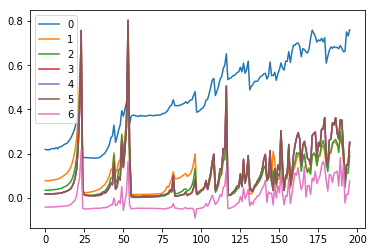

In [38]:
for l in model.act_means: 
    plt.plot(l)
plt.legend(range(len(model.act_means)));

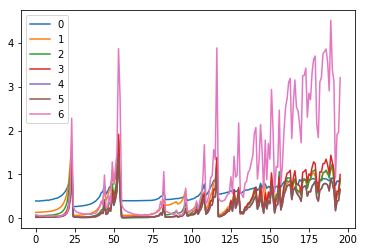

In [39]:
for l in model.act_stds: 
    plt.plot(l)
plt.legend(range(len(model.act_stds)));

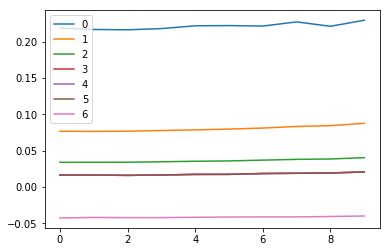

In [40]:
for l in model.act_means: 
    plt.plot(l[:10])
plt.legend(range(len(model.act_means)));

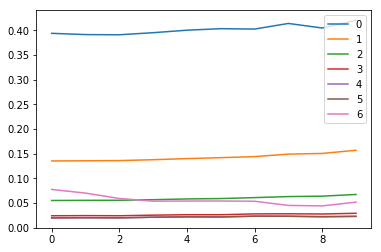

In [47]:
for l in model.act_stds: 
    plt.plot(l[:10])
plt.legend(range(len(model.act_stds)));

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [48]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [49]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [50]:
def append_stats(i, mod, inp, outp):
    if mod.training:
        act_means[i].append(outp.data.mean())
        act_stds[i].append(outp.data.std())

In [51]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [52]:
run.fit(1, learn)

train: [1.82439109375, tensor(0.3697, device='cuda:0')]
valid: [0.47832578125, tensor(0.8610, device='cuda:0')]


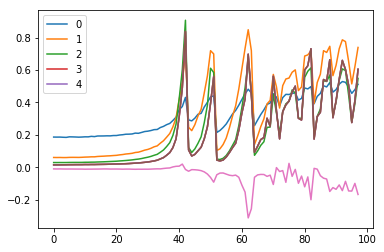

In [53]:
for l in act_means: 
    plt.plot(l)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [98]:
#export
def children(m):
    return list(m.children())


class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    means, stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds.append(outp.data.std())

In [99]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [100]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [101]:
run.fit(1, learn)

train: [2.17148640625, tensor(0.2154, device='cuda:0')]
valid: [0.836873828125, tensor(0.7485, device='cuda:0')]


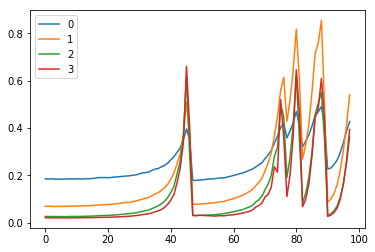

In [102]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

In [103]:
#export
class ListContainer():
    def __init__(self, items):
        self.items = listify(items)
        
    def __getitem__(self, idx):
        try:
            return self.items[idx]
        except TypeError:
            if isinstance(idx[0], bool):
                assert len(idx) == len(self)
                return [o for m, o in zip(idx, self.items) if m]
            return [self.items[i] for i in idx]
    
    def __len__(self):
        return len(self.items)
    
    def __iter__(self):
        return iter(self.items)
    
    def __setitem__(self, i, o):
        self.items[i] = o
        
    def __delitem__(self, i):
        del(self.items[i])
        
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10:
            res = res[:-1] + '...]'
        return res

In [104]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [105]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [106]:
t = ListContainer(range(10))
t[[1, 2]], t[[False]*8 + [True, False]]

([1, 2], [8])

In [107]:
t[tensor(3)]

3

In [108]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.remove()
        
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    
    def remove(self):
        for h in self:
            h.remove()
        

In [109]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [110]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f7349192438>, <__main__.Hook object at 0x7f7349192c18>, <__main__.Hook object at 0x7f73491c6c18>, <__main__.Hook object at 0x7f73491c00f0>, <__main__.Hook object at 0x7f73491c02e8>, <__main__.Hook object at 0x7f73491c0128>, <__main__.Hook object at 0x7f73491c0ba8>]

In [111]:
hooks.remove()

In [112]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [113]:
x.mean(), x.std()

(tensor(0.0056, device='cuda:0'), tensor(1.0067, device='cuda:0'))

In [114]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1711, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.2649, device='cuda:0', grad_fn=<StdBackward0>))

In [115]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [116]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4846, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.7731, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.8301959375, tensor(0.3520, device='cuda:0')]
valid: [0.42226533203125, tensor(0.8437, device='cuda:0')]
train: [0.29532326171875, tensor(0.9057, device='cuda:0')]
valid: [0.13064581298828126, tensor(0.9599, device='cuda:0')]


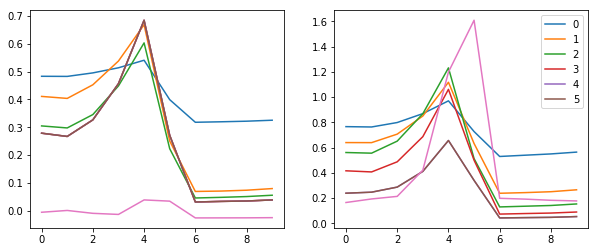

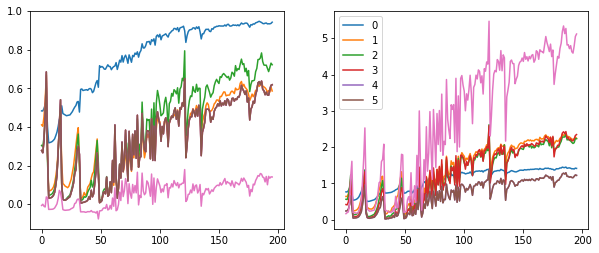

In [117]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [147]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40, 0, 10))

In [148]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [149]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [150]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [2.72388, tensor(0.1405, device='cuda:0')]
valid: [2.3459279296875, tensor(0.0929, device='cuda:0')]


In [151]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

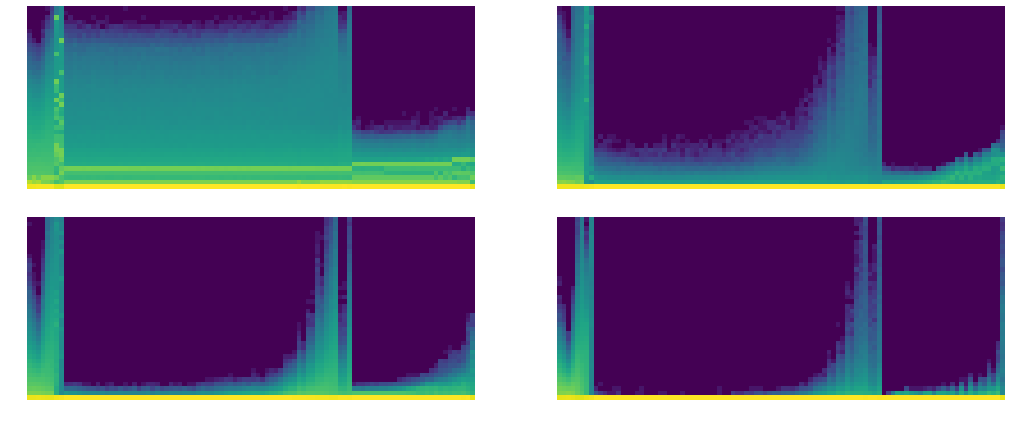

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [153]:
hooks[:4]

In [154]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

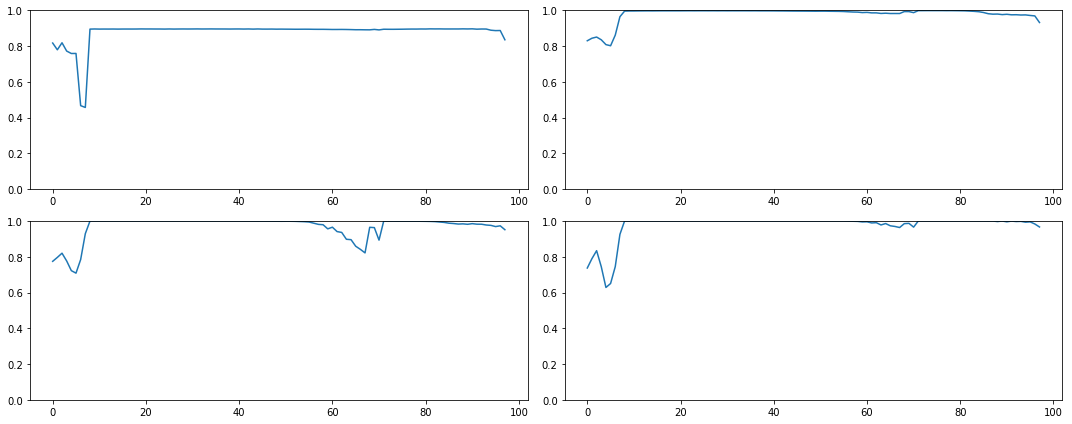

In [156]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [165]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs) - 1)] + [
                nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)
            ]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs)
    )

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
            
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [166]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40, -7, 7))
    

In [167]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5007876953125, tensor(0.8422, device='cuda:0')]
valid: [0.15431702880859374, tensor(0.9544, device='cuda:0')]


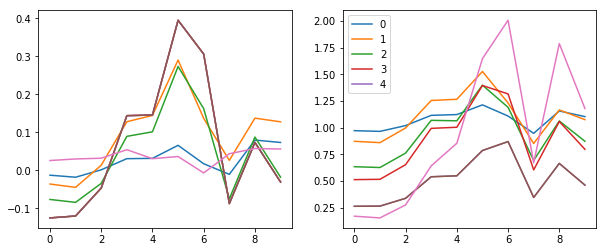

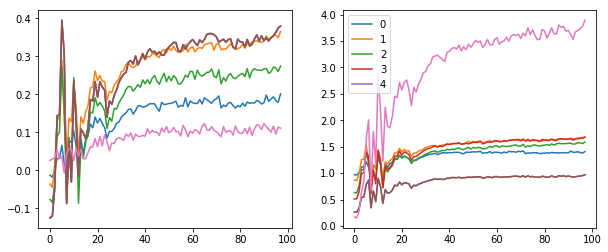

In [168]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(5))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

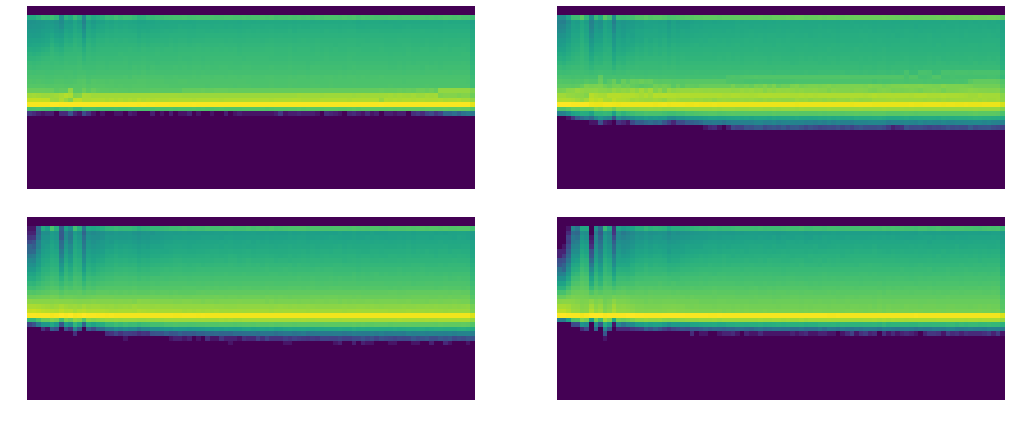

In [170]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [171]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

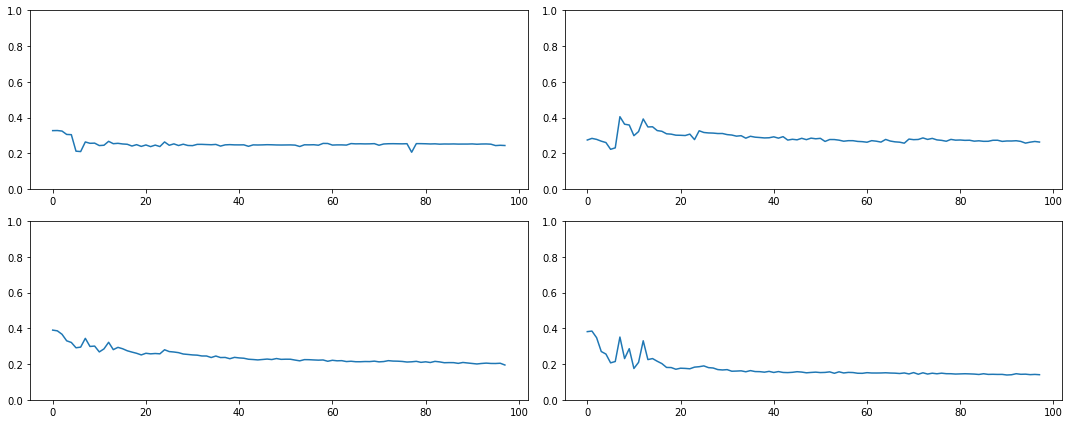

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
plt.tight_layout()

In [173]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [178]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [179]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, 
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [180]:
run.fit(8, learn)

train: [1.154338125, tensor(0.6272, device='cuda:0')]
valid: [0.2856624755859375, tensor(0.9161, device='cuda:0')]
train: [0.31086712890625, tensor(0.9075, device='cuda:0')]
valid: [0.1513021728515625, tensor(0.9551, device='cuda:0')]
train: [0.691176171875, tensor(0.7847, device='cuda:0')]
valid: [1.8890048828125, tensor(0.3130, device='cuda:0')]
train: [0.910740703125, tensor(0.7108, device='cuda:0')]
valid: [0.3340820556640625, tensor(0.8970, device='cuda:0')]
train: [0.158382138671875, tensor(0.9517, device='cuda:0')]
valid: [0.11459019775390625, tensor(0.9649, device='cuda:0')]
train: [0.09563046875, tensor(0.9707, device='cuda:0')]
valid: [0.09119310302734375, tensor(0.9724, device='cuda:0')]
train: [0.0707560302734375, tensor(0.9782, device='cuda:0')]
valid: [0.08070706787109375, tensor(0.9758, device='cuda:0')]
train: [0.059864736328125, tensor(0.9813, device='cuda:0')]
valid: [0.07776998901367188, tensor(0.9771, device='cuda:0')]


In [181]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [182]:
run.fit(8, learn)

train: [1.047697109375, tensor(0.6746, device='cuda:0')]
valid: [0.476625830078125, tensor(0.8561, device='cuda:0')]
train: [0.3306805859375, tensor(0.9007, device='cuda:0')]
valid: [0.19379718017578124, tensor(0.9398, device='cuda:0')]
train: [0.2315046875, tensor(0.9316, device='cuda:0')]
valid: [0.199136279296875, tensor(0.9449, device='cuda:0')]
train: [0.113581630859375, tensor(0.9661, device='cuda:0')]
valid: [0.09113359375, tensor(0.9720, device='cuda:0')]
train: [0.0724392724609375, tensor(0.9774, device='cuda:0')]
valid: [0.08004010620117187, tensor(0.9761, device='cuda:0')]
train: [0.0517608740234375, tensor(0.9841, device='cuda:0')]
valid: [0.06365385131835938, tensor(0.9816, device='cuda:0')]
train: [0.0370091845703125, tensor(0.9888, device='cuda:0')]
valid: [0.06076522216796875, tensor(0.9832, device='cuda:0')]
train: [0.02976200927734375, tensor(0.9911, device='cuda:0')]
valid: [0.0610428466796875, tensor(0.9833, device='cuda:0')]


In [183]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
    const ip = IPython.notebook
    if (ip) {
        ip.save_notebook()
        console.log('a')
        const s = `!python notebook2script.py ${ip.notebook_name}`
        if (ip.kernel) {
            ip.kernel.execute(s)
        }
    }
    }"""))

In [ ]:
nb_auto_export()